In [29]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import math

import torch
import matplotlib.pyplot as plt
from einops import rearrange
from typing import Union, Dict, Optional
from torch import Tensor, nn
from torch.distributions import Categorical, Normal
from torch.nn import functional as F

from bliss.catalog import TileCatalog, get_images_in_tiles, get_is_on_from_n_sources
from bliss.reporting import DetectionMetrics
from case_studies.psf_homogenization.psf_decoder import PsfSampler, GalsimBlenswithPSF
from bliss.models.detection_encoder import (
    DetectionEncoder,
    LogBackgroundTransform,
    ConcatBackgroundTransform,
    EncoderCNN,
    make_enc_final,
)


# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [8]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [9]:
# set up test data
prior = instantiate(cfg.datasets.galsim_blended_galaxies_psf.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies_psf.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 10000
n_batches = 1
psf_sampler = PsfSampler(0.5, 1.2)

ds_psf = GalsimBlenswithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=1, psf_sampler=psf_sampler, std_psf_fwhm=1.0, valid_n_batches=1)



torch.Size([5, 1, 88, 88])
torch.Size([5, 1, 88, 88])



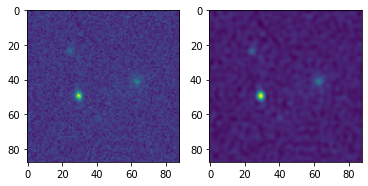

In [10]:
for x in ds_psf.train_dataloader():
    print(x["images"].shape)
    print(x["noisy_image"].shape)
    print()
    plt.figure()
    plt.subplot(121)
    plt.imshow(x['noisy_image'][0, 0].numpy())
    plt.subplot(122)
    plt.imshow(x["images"][0, 0].numpy())
    plt.show()
plt.close()

In [36]:
# load checkpoint
model_checkpoint = torch.load("/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/std=1.0/checkpoints/epoch=989-val_loss=-0.015.ckpt")
model = DetectionEncoder.load_from_checkpoint(checkpoint_path="/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/std=1.0/checkpoints/epoch=989-val_loss=-0.015.ckpt")


TypeError: __init__() missing 10 required positional arguments: 'input_transform', 'mean_detections', 'max_detections', 'n_bands', 'tile_slen', 'ptile_slen', 'channel', 'dropout', 'hidden', and 'spatial_dropout'

{"ModelCheckpoint{'monitor': 'val/loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': False}": {'monitor': 'val/loss',
  'best_model_score': tensor(-0.0147, device='cuda:0'),
  'best_model_path': '/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/version_0/checkpoints/epoch=989-val_loss=-0.015.ckpt',
  'current_score': tensor(-0.0147, device='cuda:0'),
  'dirpath': '/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/version_0/checkpoints',
  'best_k_models': {'/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/version_0/checkpoints/epoch=989-val_loss=-0.015.ckpt': tensor(-0.0147, device='cuda:0')},
  'kth_best_model_path': '/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/version_0/checkpoints/epoch=989-val_loss=-0.015

In [13]:
# set up functions for test
n_bands = 1
tile_slen = 4
ptile_slen = 52
mean_detection = 0.03
max_detection = 1
channel = 8
spatial_dropout = 0.0
hidden = 128
dropout = 0.0

def dist_param_groups():
        return {
            "loc_mean": {"dim": 2},
            "loc_logvar": {"dim": 2},
            "log_flux_mean": {"dim": n_bands},
            "log_flux_logvar": {"dim": n_bands},
        }

n_params_per_source = sum(param["dim"] for param in dist_param_groups().values())
n_total_detections = max_detection * (max_detection + 1) // 2
n_source_params = n_total_detections * n_params_per_source
count_simplex_dim = 1 + max_detection
dim_out_all = n_source_params + count_simplex_dim
dim_enc_conv_out = ((ptile_slen + 1) // 2 + 1) // 2

input_transform = ConcatBackgroundTransform()
n_bands_in = input_transform.output_channels(n_bands)
enc_conv = EncoderCNN(n_bands_in, channel, spatial_dropout)

enc_final = make_enc_final(
    channel * 4 * dim_enc_conv_out ** 2,
    hidden,
    dim_out_all,
    dropout,
)
log_softmax = nn.LogSoftmax(dim=1)

md, ntd = max_detection, n_total_detections
n_detections_map = torch.full((md + 1, md), ntd, device="cuda:0")


In [37]:
detect = DetectionEncoder(
    input_transform, 
    mean_detection, 
    max_detection, 
    n_bands,
    tile_slen, 
    ptile_slen,
    channel,
    dropout,
    hidden,
    spatial_dropout,
    )
model = detect.load_from_checkpoint("/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/std=1.0/checkpoints/epoch=989-val_loss=-0.015.ckpt")

TypeError: __init__() missing 10 required positional arguments: 'input_transform', 'mean_detections', 'max_detections', 'n_bands', 'tile_slen', 'ptile_slen', 'channel', 'dropout', 'hidden', and 'spatial_dropout'

In [25]:
def validation_step(self, batch):
        """Pytorch lightning method."""
        batch_size = len(batch["images"])
        out = self._get_loss(batch)

        # log all losses
        self.log("val/loss", out["loss"], batch_size=batch_size)
        self.log("val/counter_loss", out["counter_loss"].mean(), batch_size=batch_size)
        self.log("val/locs_loss", out["locs_loss"].mean(), batch_size=batch_size)
        self.log("val/star_params_loss", out["star_params_loss"].mean(), batch_size=batch_size)

        catalog_dict = {
            "locs": batch["locs"][:, :, :, 0 : self.max_detections],
            "log_fluxes": batch["log_fluxes"][:, :, :, 0 : self.max_detections],
            "galaxy_bools": batch["galaxy_bools"][:, :, :, 0 : self.max_detections],
            "n_sources": batch["n_sources"].clamp(max=self.max_detections),
        }
        true_tile_catalog = TileCatalog(self.tile_slen, catalog_dict)
        true_full_catalog = true_tile_catalog.to_full_params()
        image_ptiles = get_images_in_tiles(
            torch.cat((batch["images"], batch["background"]), dim=1),
            self.tile_slen,
            self.ptile_slen,
        )
        image_ptiles = rearrange(image_ptiles, "n nth ntw b h w -> (n nth ntw) b h w")
        dist_params = self.encode(image_ptiles)
        est_catalog_dict = self.variational_mode(dist_params)
        est_tile_catalog = TileCatalog.from_flat_dict(
            true_tile_catalog.tile_slen,
            true_tile_catalog.n_tiles_h,
            true_tile_catalog.n_tiles_w,
            est_catalog_dict,
        )
        est_full_catalog = est_tile_catalog.to_full_params()

        metrics = self.val_detection_metrics(true_full_catalog, est_full_catalog)
        self.log("val/precision", metrics["precision"], batch_size=batch_size)
        self.log("val/recall", metrics["recall"], batch_size=batch_size)
        self.log("val/f1", metrics["f1"], batch_size=batch_size)
        self.log("val/avg_distance", metrics["avg_distance"], batch_size=batch_size)
        return batch


In [27]:
for x in ds_psf.train_dataloader():
    validation_step(model_checkpoint, x)

AttributeError: 'dict' object has no attribute '_get_loss'

In [20]:
model_checkpoint.encoder

AttributeError: 'dict' object has no attribute 'encoder'